In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cp
import mosek

In [7]:
# Pre-calculations for generating replicating portfolio's
gauss_x = np.arange(-4, 4, 0.0001)
gauss_y = norm.cdf(gauss_x)

def gauss_cdf_vec(x):
    # Vectorized version
    condition = np.abs(x) > 4
    return np.where(condition, norm.cdf(x), np.interp(x, gauss_x, gauss_y))

In [9]:
# Delta Hedging Error Simulation
def delta_hedging(S, K, r,mu, sigma, T,k0,k, num_steps):
    dt = T / num_steps
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    cash = -K * np.exp(-r * T) * gauss_cdf_vec(d2)
    

    # Delta hedging loop
    for i in range(1, num_steps):
        Z = np.random.normal(0,1,size = len(S))
        S_new = S * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        d1_new = (np.log(S_new / K) + (r + 0.5 * sigma**2) * (T-i*dt)) / (sigma * np.sqrt(T-i*dt))  
        dd1 = (gauss_cdf_vec(d1_new)-gauss_cdf_vec(d1))
        cash_new = np.exp(r*dt) * cash - S_new * (dd1 + k*np.abs(dd1)) -np.where(dd1 != 0, k0, 0)
        #print('S',S_new,'d1', d1_new, 'dd1',dd1,'cash',cash_new)
        S = S_new
        d1 = d1_new
        cash = cash_new
    S_pos = gauss_cdf_vec(d1) * S
    Bond_pos = cash
    Z = np.random.normal(0,1,size = len(S))
    S_new = S * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    
    return(np.abs(np.maximum(S_new-K,0)-S_pos-Bond_pos))
        

In [43]:
S0 = 1  # Initial stock price
K = 1   # Strike price
mu = 0.05  # Price drift
r = 0.01    # risk-free rate
sigma = 0.3  # Volatility
T = 1.0  # Time to maturity
k0 = 0.0002
k = 0.005
N = 50000
d_steps = np.arange(20,620,20)

In [45]:
np.random.seed(1)
#### run this code if hedge_data needs to be generated
hedge_data = np.zeros((len(d_steps), N))
S0 = np.zeros(N) + 1
for i in range(len(d_steps)):
    print(i)
    hedge_data[i:] = delta_hedging(S0, K, r,mu, sigma, T,k0,k, d_steps[i])
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [265]:
np.savetxt('hedge_data_50000.txt', hedge_data)

In [267]:
hedge_data

array([[0.00349347, 0.03463647, 0.0611554 , ..., 0.04973867, 0.02530022,
        0.03410649],
       [0.01097829, 0.00221858, 0.0144026 , ..., 0.02871446, 0.01969369,
        0.01823764],
       [0.01056223, 0.09790703, 0.01257112, ..., 0.01977995, 0.0319821 ,
        0.0051771 ],
       ...,
       [0.15234295, 0.15132183, 0.17463019, ..., 0.1937435 , 0.16324717,
        0.12868466],
       [0.15947603, 0.16673418, 0.13542916, ..., 0.15158697, 0.16031365,
        0.16903172],
       [0.15566513, 0.14004291, 0.16283574, ..., 0.18371452, 0.19859925,
        0.15364191]])

In [145]:
def f_explog_vec(x, a, b):
    e = np.exp(1)
    c1 = 1 / (b**2 * (a**2 + a) * np.exp(a - 1))
    c2 = 1 - np.exp(a) * (a * b + 1) * c1
    c3 = -np.exp(a + 1) * c1

    output = np.empty_like(x, dtype=float)
    pos = x > 0
    term = (x[pos] + e) * np.exp(a * np.log(x[pos] + e)**b)
    output[pos] = c1 * term + c2 * x[pos] + c3
    output[~pos] = np.exp(x[~pos]) - 1

    return output

def df_explog_vec(x, a, b):
    e = np.exp(1)
    
    c1 = 1 / (b**2 * (a**2 + a) * np.exp(a - 1))
    c2 = 1 - np.exp(a) * (a * b + 1) * c1

    output = np.empty_like(x, dtype=float)
    pos = x > 0

    term = np.exp(a * (np.log(x[pos] + e))**b) * (a * b * (np.log(x[pos] + e))**(b - 1) + 1)
    output[pos] = c1 * term + c2
    output[~pos] = np.exp(x[~pos])

    return output

def ddf_explog_vec(x, a, b):
    e = np.exp(1)
    
    c1 = 1 / (b**2 * (a**2 + a) * np.exp(a - 1))

    output = np.empty_like(x, dtype=float)
    pos = x > 0

    term1 = a * b / (x[pos] + e) * np.exp(a * np.log(x[pos] + e)**b)
    term2 = (b - 1) * np.log(x[pos] + e)**(b - 2) + np.log(x[pos] + e)**(b - 1) + a * b * np.log(x[pos] + e)**(2 * b - 2)
    output[pos] = c1 * term1 * term2
    output[~pos] = np.exp(x[~pos])

    return output

def CVaR_vec(x,alpha):
    return np.maximum(1/alpha*x,0)

def dCVaR_vec(x, alpha):
    return np.where(x > 0, 1 / alpha, 0)

def cvar_fast(alpha,x,f):
    n = len(f)
    order = np.argsort(x)
    x = np.sort(x)
    f = f[order]
    csum = np.cumsum(f)
    if csum[0] >= alpha:
        return(-x[0])
    else:
        k_max = np.max(np.where((csum < alpha)==True))
    Ex = np.sum(np.multiply(x[0:k_max+1],f[0:k_max+1]))
    last = (alpha - csum[k_max])*x[k_max+1]
    return(-1/alpha*(Ex+last))

In [233]:
def ellipsoid_explog_vec_BS(x0, max_iter,r_e,para):
    n = len(x0)
    x = x0
    P = np.identity(n)*r_e
    a,b,alpha,r,X = para
    f_best = np.inf
    x_opt = x0
    N = len(X)
    for steps in range(max_iter):
        if x[2] >= 0:
            the1 = x[0]
            the2 = x[1]
            lbda = x[2]
            g = np.zeros(3)
            arg = CVaR_vec(the2-X,alpha)
            f_obj = np.sum(lbda * f_explog_vec((arg+the1)/lbda,a,b))/N -the1-the2+lbda*r
            s1 = np.sum(df_explog_vec((arg+the1)/lbda,a,b))
            s2 = np.sum(df_explog_vec((arg+the1)/lbda,a,b)* dCVaR_vec(the2-X,alpha))
            s3 = np.sum(f_explog_vec((arg+the1)/lbda,a,b) - df_explog_vec((arg+the1)/lbda,a,b) * ((arg+the1)/lbda))
            
            g[0] = -1 + s1/N
            g[1] = -1 + s2/N
            g[2] = r + s3/N
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            if f_obj < f_best and x[2] >= 0:
                f_best = f_obj
                x_opt = x
                x_grad = g
            #print('obj', f_best, 'sol', x_opt, np.max(P))
        else:
            g = np.array([0,0,-1])
            #print('constr_g', (g.dot(P)).dot(g))
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            
        alfa = 0
        U = g_n.dot(P)
        c1 = (n**2/(n**2-1)) * (1-alfa**2)
        c2 = (1+n*alfa)/((n+1)*(1+alfa))*2
        x = x - (1+n*alfa)/(n+1)* P.dot(g_n)
        P = c1 * (P - c2 * np.outer(U,U))
        
        
        if np.max(P) <= 1e-6:
            print('obj', f_best, 'sol', x_opt,'grad', x_grad,'P-norm', np.max(P))
            return(x_opt, f_best, x_grad)
    
    print('max iterations reached')

    return x_opt, f_best
                
    
            
    

In [269]:
a = 1/(2*(sigma*2)**2)
b = 2
alpha = 0.05
radius = 0.1

In [271]:
#### run this code to calculate the robust hedging error and nominal hedging error

h_rob = np.zeros(len(d_steps))
h_e = np.zeros(len(d_steps))
for i in range(len(d_steps)):
    print(i)
    N_data = len(hedge_data[i])
    X = -hedge_data[i]
    para = [a,b,alpha,radius,X]
    x0 = np.array([-1,1,5])
    h_e[i] = cvar_fast(alpha,-hedge_data[i],np.zeros(N_data)+ 1/N_data)
    h_rob[i] = ellipsoid_explog_vec_BS(x0, 400,1000,para)[1]

0
obj 0.38315154062924317 sol [-0.04562178 -0.22276417  1.11581006] grad [-6.13463593e-06  1.86242419e-05  1.03166170e-05] P-norm 7.039166373253945e-07
1
obj 0.2651761199719045 sol [-0.02881407 -0.16416458  0.70211139] grad [-4.66057761e-05 -1.97389313e-04 -3.37127948e-05] P-norm 9.46808876765113e-07
2
obj 0.22173719290541102 sol [-0.02402425 -0.13752181  0.58537792] grad [-4.72088873e-07 -1.59201162e-05  3.02735997e-06] P-norm 8.368559076698872e-07
3
obj 0.20965443016337923 sol [-0.02283839 -0.1292011   0.56041554] grad [-4.45226851e-05  5.43030809e-04 -5.79750314e-06] P-norm 9.47321276419716e-07
4
obj 0.1808789939258864 sol [-0.01611676 -0.12555121  0.38229846] grad [1.41552392e-05 1.18074345e-05 2.59436238e-05] P-norm 8.214931790854741e-07
5
obj 0.17599012026054228 sol [-0.01554309 -0.12193122  0.37487194] grad [-6.87995474e-06 -5.73845826e-04  9.74629620e-05] P-norm 8.176886853876231e-07
6
obj 0.17423163965434318 sol [-0.01541747 -0.11990719  0.37807226] grad [-1.67181760e-05 -3.16

In [275]:
np.savetxt('h_rob.txt', h_rob)
np.savetxt('h_e.txt', h_e)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


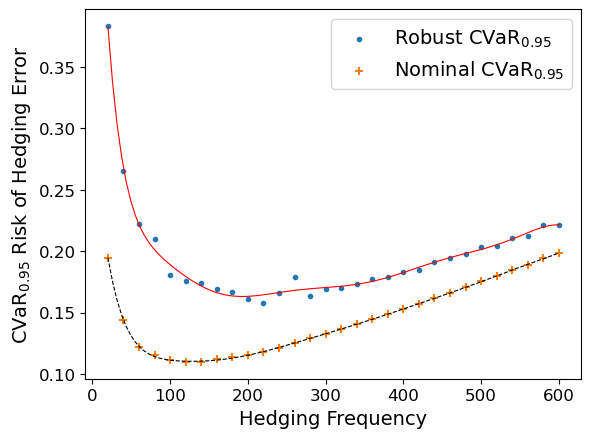

In [277]:
coefficients_rob = np.polyfit(d_steps, h_rob, 10)
coefficients_nom = np.polyfit(d_steps, h_e, 10)

# Generate points for the fitted curve
x_fit_rob = np.linspace(d_steps.min(), d_steps.max(), 100)
y_fit_rob = np.polyval(coefficients_rob, x_fit_rob)

x_fit_nom = np.linspace(d_steps.min(), d_steps.max(), 100)
y_fit_nom = np.polyval(coefficients_nom, x_fit_nom)

# Observed data
plt.scatter(d_steps, h_rob, label=r'Robust $\mathrm{CVaR}_{0.95}$', marker = '.')
plt.scatter(d_steps, h_e, label=r'Nominal $\mathrm{CVaR}_{0.95}$', marker = '+')

# Fitted Data
plt.plot(x_fit_rob, y_fit_rob, color='red', linewidth=0.8)
plt.plot(x_fit_nom, y_fit_nom, color='black', linewidth=0.8, linestyle='--')

plt.xlabel('Hedging Frequency', fontsize=14)
plt.ylabel(r'$\mathrm{CVaR}_{0.95}$ Risk of Hedging Error', fontsize=14)
plt.xticks(fontsize=12)  # Set font size for x-axis ticks
plt.yticks(fontsize=12)  # Set font size for y-axis ticks
plt.legend(fontsize=14)  # Set font size for legend

plt.savefig('BlackScholes.eps', format = 'eps')